In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from tensorboard.plugins.hparams import api as hp

In [2]:
df = pd.read_csv("../solutions/galaxyquasar.csv")
df

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [3]:
df['u-g'] = df['u']- df['g'] 
df['g-r'] = df['g']- df['r'] 
df['r-i'] = df['r']- df['i']
df['i-z'] = df['i']- df['z']

In [4]:
le = LabelEncoder()
# Assign unique integers: 1 QSO, 0 galaxy
df['class'] = le.fit_transform(df['class'] )
labels_class = le.inverse_transform(df['class'] )
class_names = le.classes_
print('Class names: ', class_names)
print('Labels: ', labels_class)

Class names:  ['GALAXY' 'QSO']
Labels:  ['QSO' 'GALAXY' 'GALAXY' ... 'GALAXY' 'GALAXY' 'GALAXY']


In [5]:
neg, pos = np.bincount(df['class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 50000
    Positive: 7134 (14.27% of total)



In [6]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.79320688])

In [7]:
scaler = StandardScaler().set_output(transform="pandas")
X_train, X_val, y_train, y_val = train_test_split(df.loc[:, 'u-g':'i-z'], df['class'], test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=9)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [8]:
%load_ext tensorboard

In [9]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([5,10,15,20]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.1, 0.2, 0.5]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['nadam', 'sgd']))
METRIC_F1SCORE = 'f1_score'

with tf.summary.create_file_writer('bias_f1_score/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_F1SCORE, display_name='F1 score')]
  )

In [10]:
def validate_model(hparams):
  output_bias = tf.keras.initializers.Constant(initial_bias)
  model = keras.Sequential([
      tf.keras.layers.InputLayer(shape=(X_train.shape[-1],)),
      keras.layers.Dense(
          hparams[HP_NUM_UNITS], activation='relu'),
      keras.layers.Dropout(hparams[HP_DROPOUT]),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss=keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.F1Score(name = 'f1_score')])
  model.fit(X_train_scaled, y_train, epochs=1)
  _, F1score = model.evaluate(X_val_scaled, y_val)
  return (F1score)

In [27]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    F1_score = validate_model(hparams)
    tf.summary.scalar(METRIC_F1SCORE, F1_score, step=1)

In [28]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for dropout_rate in (HP_DROPOUT.domain.values):
    for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_DROPOUT: dropout_rate,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('bias_f1_score/hparam_tuning/' + run_name, hparams)
      session_num += 1

--- Starting trial: run-0
{'num_units': 5, 'dropout': 0.1, 'optimizer': 'nadam'}
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - f1_score: 0.2501 - loss: 1.1779
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2461 - loss: 0.3691
--- Starting trial: run-1
{'num_units': 5, 'dropout': 0.1, 'optimizer': 'sgd'}
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - f1_score: 0.2436 - loss: 1.0754
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2461 - loss: 0.3035
--- Starting trial: run-2
{'num_units': 5, 'dropout': 0.2, 'optimizer': 'nadam'}
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - f1_score: 0.2427 - loss: 1.2120
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2460 - loss: 0.3277
--- Starting trial: run-3
{'num_units': 5, 'dropout': 0.2, 'optimizer': 'sgd'}
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - f1_score: 0.2454 - loss: 0.8615
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - f1_score: 0.2459 - loss: 0.1969
--- Starting trial: run-4
{'num_units': 5, 'dropout': 0.5, 'optimizer': 'nadam'}

KeyboardInterrupt: 

In [13]:
%tensorboard --logdir bias_f1_score/hparam_tuning --host localhost --port 7935

In [9]:
tuned_num_units = 15
tuned_dropout = 0.1
tuned_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [10]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),
      keras.metrics.BinaryAccuracy(name='binary accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.F1Score(name='F1_score', threshold = 0.5),
    # same as model's loss
]

def make_model(metrics=METRICS, output_bias=None):
  output_bias = tf.keras.initializers.Constant(3*initial_bias)
  model = keras.Sequential([
      tf.keras.layers.InputLayer(shape=(X_train.shape[-1],)),
      keras.layers.Dense(
          tuned_num_units, activation='relu',
          ),
      keras.layers.Dropout(tuned_dropout),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=tuned_optimizer,
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  #print(metrics)
  return model

In [11]:
model = make_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 15)                  │              75 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91 (364.00 B)

 Trainable params: 91 (364.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model.fit(X_train_scaled, y_train, epochs=20, validation_data=(X_val_scaled, y_val))

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - F1_score: 0.2593 - binary accuracy: 0.8784 - cross entropy: 0.5295 - loss: 0.5295 - precision: 0.6016 - recall: 0.1775 - val_F1_score: 0.8910 - val_binary accuracy: 0.9695 - val_cross entropy: 0.1321 - val_loss: 0.1321 - val_precision: 0.9317 - val_recall: 0.8537
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - F1_score: 0.8504 - binary accuracy: 0.9600 - cross entropy: 0.1433 - loss: 0.1433 - precision: 0.9019 - recall: 0.8045 - val_F1_score: 0.9278 - val_binary accuracy: 0.9795 - val_cross entropy: 0.0883 - val_loss: 0.0883 - val_precision: 0.9524 - val_recall: 0.9045
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - F1_score: 0.8968 - binary accuracy: 0.9716 - cross entropy: 0.1039 - loss: 0.1039 - precision: 0.9359 - recall: 0.8609 - val_F1_score: 0.9363 - val_binary accuracy: 0.9818 - val_cross entropy: 0.0773 - val_loss: 0.0773 - val_precision: 0.9566 - val_recall: 0.9168
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms

In [13]:
train_predictions = model.predict(X_train_scaled)
val_predictions = model.predict(X_val_scaled)
test_predictions = model.predict(X_test_scaled)

875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [14]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix with threshold = {:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Galaxies correctly detected as galaxies (True Positives): ', cm[0][0])
  print('Galaxies mistakely detected as QSO (False Positives): ', cm[0][1])
  print('QSO mistakely detected as galaxies (False Negatives): ', cm[1][0])
  print('QSO  correctly detected as QSO (True Negatives): ', cm[1][1])
  print('Total galaxies: ', np.sum(cm[0]))
  print('Total QSO: ', np.sum(cm[1]))

loss :  0.07132277637720108
compile_metrics :  0.07132277637720108

Galaxies correctly detected as galaxies (True Positives):  12713
Galaxies mistakely detected as QSO (False Positives):  99
QSO mistakely detected as galaxies (False Negatives):  158
QSO  correctly detected as QSO (True Negatives):  2030
Total galaxies:  12812
Total QSO:  2188


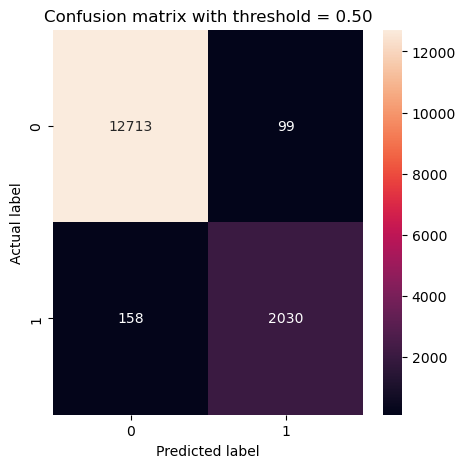

In [15]:
val_results = model.evaluate(X_val_scaled, y_val, verbose=0)
for name, value in zip(model.metrics_names, val_results):
  print(name, ': ', value)
print()

plot_cm(y_val, val_predictions, threshold = 0.5)

loss :  0.07044462114572525
compile_metrics :  0.07044462114572525

Galaxies correctly detected as galaxies (True Positives):  5969
Galaxies mistakely detected as QSO (False Positives):  39
QSO mistakely detected as galaxies (False Negatives):  80
QSO  correctly detected as QSO (True Negatives):  912
Total galaxies:  6008
Total QSO:  992


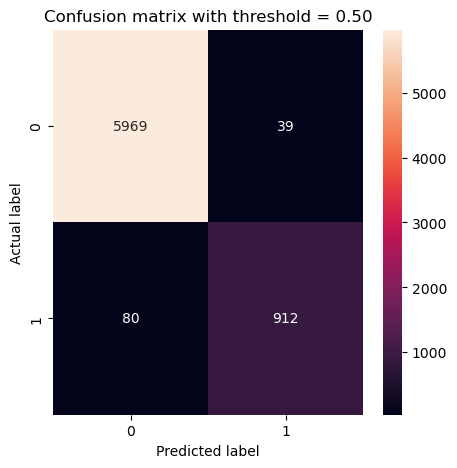

In [16]:
test_results = model.evaluate(X_test_scaled, y_test, verbose=0)
for name, value in zip(model.metrics_names, test_results):
  print(name, ': ', value)
print()

plot_cm(y_test, test_predictions, threshold = 0.5)

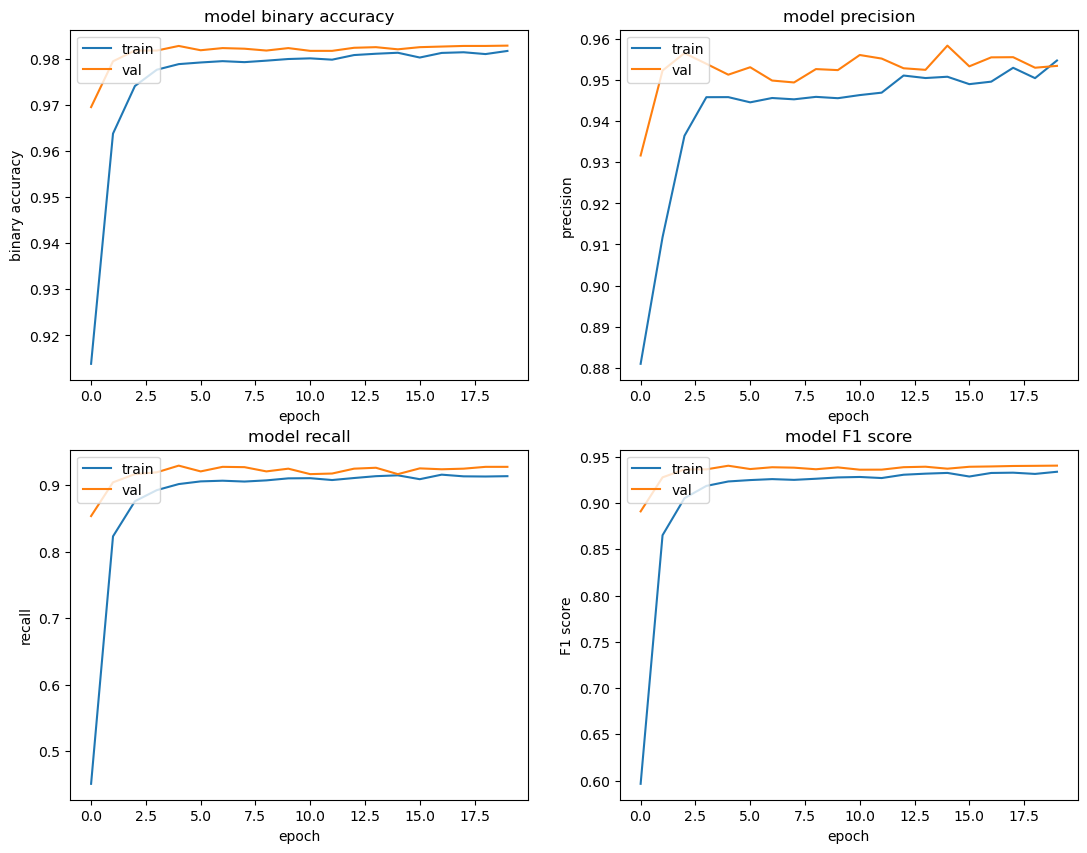

In [20]:
fig = plt.figure(figsize = (13,10))
ax = fig.add_subplot(221)
ax.plot(history.history['binary accuracy'])
ax.plot(history.history['val_binary accuracy'])
ax.set_title('model binary accuracy')
ax.set_ylabel('binary accuracy')
ax.set_xlabel('epoch')
ax.legend(['train', 'val'], loc='upper left')

ax1 = fig.add_subplot(222)
ax1.plot(history.history['precision'])
ax1.plot(history.history['val_precision'])
ax1.set_title('model precision')
ax1.set_ylabel('precision')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax3 = fig.add_subplot(223)
ax3.plot(history.history['recall'])
ax3.plot(history.history['val_recall'])
ax3.set_title('model recall')
ax3.set_ylabel('recall')
ax3.set_xlabel('epoch')
ax3.legend(['train', 'val'], loc='upper left')
epoque = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

ax2 = fig.add_subplot(224)
ax2.plot(history.history['F1_score'])
ax2.plot(history.history['val_F1_score'])
ax2.set_title('model F1 score')
ax2.set_ylabel('F1 score')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

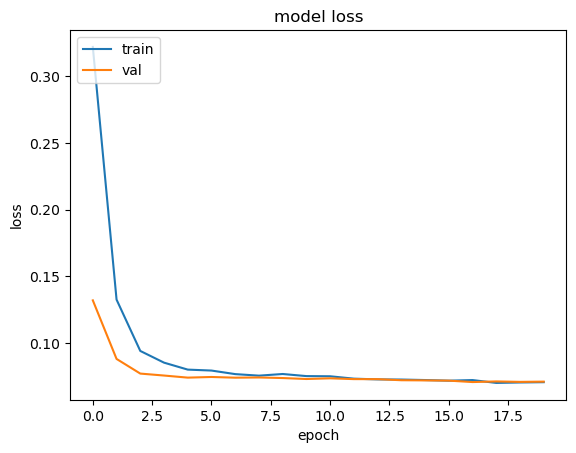

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
from sklearn.metrics import classification_report

report = classification_report(y_test, model.predict(X_test_scaled) > 0.5)
print(report)   

219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      6008
           1       0.96      0.92      0.94       992

    accuracy                           0.98      7000
   macro avg       0.97      0.96      0.96      7000
weighted avg       0.98      0.98      0.98      7000

